# p-Hacking和多重比较偏差

By Delaney Mackenzie and Maxwell Margenot.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

多重比较偏差是统计学、数据科学和一般预测中普遍存在的问题。简单的解释是，您运行的测试越多，得到您想要/期望的结果的可能性就越大。如果您忽略了大量失败的测试，那么很明显，您误解了数据中发生的事情，从而导致了失败。

一个特别常见的例子是在由许多独立序列或变量组成的大型数据集中寻找关系。在这种情况下，每次评估一组变量之间是否存在关系时，都要运行一个测试。


## 统计数字只是说明了这个问题

在现实生活中，大多数人也会受到多重比较偏差的影响。任何时候你做了一个决定，你都是在一个假设的基础上采取了有效的行动。这种假设经常被验证。你可能会在日常生活中不知不觉地做很多测试。

一个例子可能是决定哪种药物可以帮助治愈你的感冒。许多人会同时服用多种药物来试图摆脱症状。你可能认为某种药物起作用了，但实际上没有任何药物起作用，感冒只是在某一时刻开始好转。

这里的要点是，这个问题不是源于统计测试和p值。相反，这些技术为我们提供了关于问题的更多信息，以及它可能在什么时候发生。

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

### 复习一下:斯皮尔曼等级相关性

请参考[本次讲座](https://www.quantopian.com/lectures/spearman-rank-correlation)以获得更完整的信息，但这里有一个关于Spearman等级相关性的非常简短的复习。

这是一种考虑到数据等级的相关性变化。这可以帮助解决会混淆其他度量的奇怪分布或异常值的问题。测试还返回一个p值，这是关键。

系数越大，估计关系越强。

In [5]:
X = pd.Series(np.random.normal(0,1,100))
Y = X

r_s = stats.spearmanr(Y, X)
print( 'Spearman Rank Coefficient: ', r_s[0])
print('p-value: ', r_s[1]) 

Spearman Rank Coefficient:  0.9999999999999999
p-value:  0.0


如果我们添加一些噪声，我们的系数就会下降。

In [6]:
X = pd.Series(np.random.normal(0, 1, 100))
Y = X + np.random.normal(0, 1, 100)

r_s = stats.spearmanr(Y, X)
print('Spearman Rank Coefficient: ', r_s[0]) 
print( 'p-value: ', r_s[1])

Spearman Rank Coefficient:  0.616909690969097
p-value:  8.232845046906763e-12


### 复习一下：p值

有关p值的更多信息请参见[本讲座](https://www.quantopian.com/lectures/hypothesis-testing)。重要的是要记住它们是用来测试给定数据的假设的。在这里，我们测试的假设给定序列值的两个序列之间存在关系。

重要:p值必须被当作二元地。

一个常见的错误是p值被认为是更显著或更不显著。这是一个糟糕的做法，因为它允许所谓的[p-hacking](https://en.wikipedia.org/wiki/Data_dredging)，并将导致比您预期更多的误报。实际上，您很可能会说服自己数据中存在关系。

要将p值视为二元地，必须预先设置截断值。然后必须将p值与截止值进行比较，并将其视为显著性/非显著性。我们来看看这个。

### 临界值是我们的显著性水平

我们可以将截止值作为我们的显著性水平，因为较低的截止值意味着通过它的结果在较高的置信水平上是显著的。如果你的截止值是0.05，那么即使是随机数据，也有5%的测试是随机通过的。0.01的截止值将这个值降低到1%，这是一个更严格的测试。因此，我们可以对我们的结果更有信心。

In [8]:
# Setting a cutoff of 5% means that there is a 5% chance
# of us getting a significant p-value given no relationship
# in our data (false positive).
# NOTE: This is only true if the test's assumptions have been
# satisfied and the test is therefore properly calibrated.
# All tests have different assumptions.
cutoff = 0.05

X = pd.Series(np.random.normal(0, 1, 100))
Y = X + np.random.normal(0, 1, 100)

r_s = stats.spearmanr(Y, X)
print('Spearman Rank Coefficient: ', r_s[0]) 
print( 'p-value: ', r_s[1])
if r_s[1] < cutoff:
    print('There is significant evidence of a relationship.') 
else:
    print ('There is not significant evidence of a relationship.')

Spearman Rank Coefficient:  0.7268046804680467
p-value:  1.1274861682228768e-17
There is significant evidence of a relationship.


## 实验-运行许多测试

我们将从定义一个DataFrame开始。

In [9]:
df = pd.DataFrame()

现在我们将通过添加`N`次随机生成的长度为`T`的时间序列来填充它。

In [19]:
N = 20
T = 100

for i in range(N):
    X = np.random.normal(0, 1, T)
    X = pd.Series(X)
    name = 'X%s' % i
    df[name] = X

In [11]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,0.711291,0.521319,-0.174280,1.331256,0.148779,-0.973874,0.017122,0.482309,-0.720389,0.516888,0.383631,0.708159,0.137160,-1.367894,0.900423,1.521880,-0.425836,-0.566939,1.075939,-1.127091
1,-0.162657,-1.457196,-0.926177,0.898065,-1.541169,0.189195,0.456709,-0.273425,-0.002375,0.226331,-0.714121,0.376299,1.780852,-0.201388,-0.526601,-0.496015,-0.942472,-0.771762,1.269508,1.895781
2,0.718668,1.053892,0.383983,0.574620,1.784224,-1.536690,-0.586098,0.588320,1.382693,-1.448111,0.416505,0.023832,0.227777,0.194902,0.496966,-0.638934,-1.181640,1.391174,-2.701763,-0.115987
3,1.062505,0.386135,-0.756125,-0.085422,-2.122664,-1.655983,0.839018,-1.467402,0.089964,-1.332817,-2.617708,-2.306327,0.341659,1.036582,-1.331616,0.813479,0.795033,0.250137,1.791160,-1.213683
4,-1.617946,-1.652482,1.166963,-1.221003,-0.175400,-0.093413,-0.414503,-0.857690,0.660222,0.555540,0.218885,-1.803355,-1.519534,-0.978117,0.937327,1.707044,0.511242,0.450364,-1.910801,-0.871813


现在，我们将在数据中的所有对上运行一个测试，寻找p值低于我们定义的阈值5%的实例。

In [20]:
cutoff = 0.05

significant_pairs = []

for i in range(N):
    for j in range(i+1, N):
        Xi = df.iloc[:, i]
        Xj = df.iloc[:, j]
        
        results = stats.spearmanr(Xi, Xj)
        pvalue = results[1]
        
        if pvalue < cutoff:
            significant_pairs.append((i, j))

在我们检查我们得到了多少显著的结果之前，让我们运行一些数学来检查我们期望得到多少。N个序列的对的个数的公式是

$$\frac{N(N-1)}{2}$$

我们的数据中没有任何关系，因为它们都是随机生成的。如果我们的测试是正确校准的，在给定5%的显著性水平后我们应该预期的假阳性率为5%。因此，我们应该期望以下基于纯随机机会而获得显著性的对的数量。

In [13]:
(N * (N-1) / 2) * 0.05

9.5

现在我们来比较一下我们实际找到了多少。

In [21]:
len(significant_pairs)

9

我们不应该期望这些数字在一致的基础上匹配得太紧密，因为我们只做了一个实验。如果我们进行许多这样的实验，我们应该会看到一个收敛到我们所期望的。

### 重复实验

In [24]:
def do_experiment(N, T, cutoff=0.05):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    significant_pairs = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)

            pvalue = results[1]

            if pvalue < cutoff:
                significant_pairs.append((i, j))
    
    return significant_pairs


num_experiments = 100

results = np.zeros(num_experiments)

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.05)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

The average over many experiments should be closer.

In [25]:
np.mean(results)

9.87

## 将发生了什么可视化

这里发生的是p值应该是均匀分布的，在底层数据中没有信号。基本上，它们不携带任何信息，其概率为0.01，等于0.99。因为它们是随机跳出来的，你会期望一定比例的p值低于你选择的阈值。cutoff越低，通过测试的实验就越少。

让我们通过创建一个返回p值的修改后的函数来形象化这一点。

In [26]:
def get_pvalues_from_experiment(N, T):
    df = pd.DataFrame()

    # Make random data
    for i in range(N):
        X = np.random.normal(0, 1, T)
        X = pd.Series(X)
        name = 'X%s' % i
        df[name] = X

    pvalues = []

    # Look for relationships
    for i in range(N):
        for j in range(i+1, N):
            Xi = df.iloc[:, i]
            Xj = df.iloc[:, j]

            results = stats.spearmanr(Xi, Xj)
            pvalue = results[1]
            pvalues.append(pvalue)
    
    return pvalues

现在我们将收集一堆p值。在任何情况下，我们都需要收集大量的p值来开始了解底层分布的情况。如果我们只收集少数，它将是这样的嘈杂:

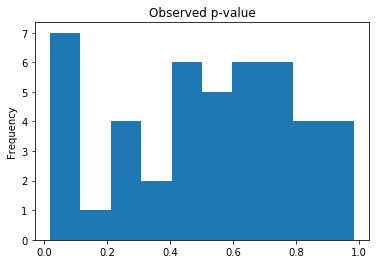

In [27]:
pvalues = get_pvalues_from_experiment(10, 100)
plt.hist(pvalues)
plt.ylabel('Frequency')
plt.title('Observed p-value');

让我们调高参数`N`来更好地理解它。请记住，p值的数量将以以下的速度增加

$$\frac{N (N-1)}{2}$$

或大约是抛物线。因此，我们不需要让N增加太多。

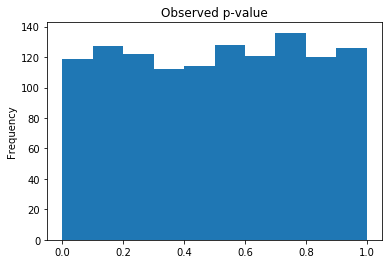

In [28]:
pvalues = get_pvalues_from_experiment(50, 100)
plt.hist(pvalues)
plt.ylabel('Frequency')
plt.title('Observed p-value');

开始看起来很平，正如我们所料。最后，为了可视化绘制边界的过程，我们将绘制两条人工线。

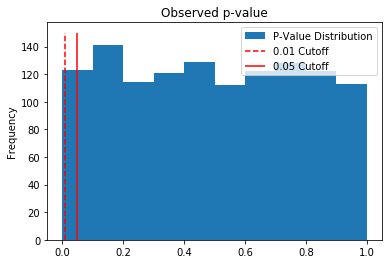

In [29]:
pvalues = get_pvalues_from_experiment(50, 100)
plt.vlines(0.01, 0, 150, colors='r', linestyle='--', label='0.01 Cutoff')
plt.vlines(0.05, 0, 150, colors='r', label='0.05 Cutoff')
plt.hist(pvalues, label='P-Value Distribution')
plt.legend()
plt.ylabel('Frequency')
plt.title('Observed p-value');

我们可以看到，在较低的临界值下，我们应该期望得到更少的误报。让我们用上面的实验来验证一下。

In [30]:
num_experiments = 100

results = np.zeros(num_experiments)

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=0.01)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

In [31]:
np.mean(results)

1.99

最后将它与我们预期的进行比较。

In [32]:
(N * (N-1) / 2) * 0.01

1.9000000000000001

## 敏感性/特异性权衡

对于任何p值截断的调整，我们都需要权衡。较低的分界点降低了误报率，但也降低了我们找到真实关系(真阳性)的机会。所以你不能为了解决这个问题而降低截止值。

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

## 减少多重比较偏差

你不能消除多重比较偏差，但你可以减少它对你的影响。为此，我们有两种选择。

### 选项1:运行更少的测试。

这通常是最好的选择。不要只是四处搜寻，希望找到一个有趣的信号，而是要利用你对系统的专业知识来开发一个伟大的假设，并对其进行测试。这种对数据进行探索、提出假设、收集更多数据并对新数据进行假设检验的过程被认为是统计和科学研究的黄金标准。至关重要的是，你用来建立假设的数据集不能用来验证它。因为你在探索过程中发现了这种效果，所以测试很可能会通过，而不会真正告诉你任何东西。你想知道的是效果有多一致。迁移到新的数据并在那里进行测试不仅意味着您只运行一个测试，而且将是对您的假设是否正确的“无偏估计”。我们在其他课上讨论了很多。

### 选择二:调整因子和邦费罗尼修正

#### 警告:这部分有点技术性。除非您熟悉显著性水平，否则我们建议您先查看代码示例，并在深入阅读文本之前阅读相关文章。

如果必须运行许多测试，请尝试纠正p值。这意味着在确定p值是否重要时，要对截断值应用一个校正因子，以获得实际使用的截断值。最保守、最常见的修正因子是Bon Ferroni。

### 例子:Bon Ferroni校正

Bon Ferroni背后的概念非常简单。它只是说，如果我们运行$m$次测试，并且我们有一个$a$的显著性水平/截止值，那么在确定显著性时，我们应该使用$a/m$作为我们的新截止值。下面是计算出的结果。

假设我们运行$m$测试。我们应该期望看到$ma$基于随机机会通过截止值的假阳性。如果我们使用$a/m$作为我们的边界，那么我们应该期望看到$ma/m = a$测试通过我们的边界。因此，我们回到了期望的假阳性率$a$。

让我们在上面的实验中尝试一下。

In [33]:
num_experiments = 100

results = np.zeros((num_experiments,))

N = 20
T = 100
desired_level = 0.05
num_tests = N * (N - 1) / 2
new_cutoff = desired_level / num_tests

for i in range(num_experiments):
    # Run a single experiment
    result = do_experiment(20, 100, cutoff=new_cutoff)
    
    # Count how many pairs
    n = len(result)
    
    # Add to array
    results[i] = n

In [34]:
np.mean(results)

0.04

正如您所看到的，我们的显著结果的数量现在远远低于平均水平。这很好，因为数据一开始就是随机的。

### 这些通常过于保守

因为邦费罗尼是如此的严格，你经常会错过真正的关系。在下面的文章中有一个很好的例子

https://en.wikipedia.org/wiki/Multiple_comparisons_problem

实际上，它假设您正在运行的所有测试都是独立的，并且不考虑数据中的任何结构。你也许可以设计一个更精细的校正因子，但这给你的研究增加了一层复杂性，也因此增加了一个失败点。一般来说，任何时候你放松你的严格，你需要非常小心，不要犯错误。

由于Bon Ferroni过于热心，所以通常运行更少的测试是更好的选择。或者，如果必须运行多个测试，则保留多个数据集，以便您的候选信号可以进行一轮样本外测试。例如，您可能有以下流程:

* 假设有10万种可能的关系。
* 对每一个可能的关系运行一个测试，并选择那些通过测试的。
* 使用这些候选数据，对一组新的样本外数据运行测试。因为您有更少的候选数据，您现在可以应用邦费罗尼更正这些p值，或在必要时重复另一轮的样本外测试。

# p-Hacking是什么?

p-hacking只是有意或无意地滥用多重比较偏差。这是令人惊讶的普遍现象，即使在学术文献中也是如此。优秀的统计新闻网站FiveThirtyEight在这里有一个很好的可视化:

https://fivethirtyeight.com/features/science-isnt-broken/

维基百科的文章也提供了丰富的信息:

https://en.wikipedia.org/wiki/Data_dredging

一般来说，这个概念很简单。通过运行许多测试或实验，然后只关注那些有效的测试或实验，您可以将假阳性结果呈现为真实结果。请记住，这也适用于在不同的数据集上运行许多不同的模型或不同类型的实验。想象一下，你花了一个夏天的时间研究一种预测未来玉米价格的新模型。您尝试了50种不同的模型，直到最后一种成功。这只是运气吗?当然，在相信模型是有效的之前，您需要更加小心地验证模型并在新数据上进行样本外测试。

# 最后指出

## 你永远无法消除，只能减少风险。

一般来说，你不可能完全消除多重比较偏差，你只能使用我们上面描述的技术来降低误报的风险。在一天结束的时候，在研究中尝试的大多数想法都不奏效，所以随着时间的推移，你最终会测试许多不同的假设。只要小心一点，用常识判断是否有足够的证据证明一个假设是正确的，或者你只是碰巧在这个迭代中得到了幸运的结果。

## 使用样本外测试

如上所述，样本外测试是降低风险的最佳方法之一。无论在什么情况下，你都应该使用它。通常，假阳性通过您的工作流的原因之一是在最后缺少样本外测试。

#### 参考

 * https://en.wikipedia.org/wiki/Multiple_comparisons_problem
 * https://en.wikipedia.org/wiki/Sensitivity_and_specificity
 * https://en.wikipedia.org/wiki/Bonferroni_correction
 * https://fivethirtyeight.com/features/science-isnt-broken/